OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August, September 2022

# PART 2 : Exploratory Data Analysis of the dataset

#### Idea

The variable that we want to predict is : "TotalGHGEmissions" which represents the amount of CO2 emitted.

1) Correlation Matrix :
    - Feature Engineering : delete features that are correlated.

2) Data visualization of "TotalGHGEmissions" and categorical features (like "BuildingType" for instance)

3) Study distribution of quantitative features (energy variables etc)
    - Feature Engineering : verify the coefficient of skewness
    - Feature Engineering : apply logarithmic transformation


#### Importing libraries

In [147]:
import numpy as np
%reset -f

import warnings

# warnings.filterwarnings('once')
warnings.filterwarnings(action="ignore")

from exploration import *

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [148]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.set_option('display.max_columns', None)

# Starting time
t0 = time()

#### Loading dataset

In [149]:
columns_to_categorize = ["OSEBuildingID", "BuildingType", "PrimaryPropertyType", "Neighborhood", "ZipCode",
                         "CouncilDistrictCode",
                         "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]

columns_to_categorize = {column: 'object' for column in columns_to_categorize}

print("This dictionary will be used when reading the csv file to assign a type to categorical features :",
      columns_to_categorize)

This dictionary will be used when reading the csv file to assign a type to categorical features : {'OSEBuildingID': 'object', 'BuildingType': 'object', 'PrimaryPropertyType': 'object', 'Neighborhood': 'object', 'ZipCode': 'object', 'CouncilDistrictCode': 'object', 'LargestPropertyUseType': 'object', 'SecondLargestPropertyUseType': 'object', 'ThirdLargestPropertyUseType': 'object'}


In [150]:
input_path = "./dataset/cleaned/"
input_filename = "data_cleaned.csv"

input_dataset_file = "{}{}".format(input_path, input_filename)
# we assign the categorical features with a categorical type
cleaned_data = pd.read_csv(input_dataset_file, dtype=columns_to_categorize)

In [151]:
cleaned_data.shape

(3147, 32)

In [152]:
cleaned_data[:10]

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),TotalEnergy(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,Nonresidential,Hotel,98101.0,7,Downtown,1927,1,12,88434,0,88434,Hotel,88434,No use,0,No use,0,60,82,84,182,189,7226362,7456910,2003882,1156514,3946027,12765,1276453,250,3
1,2,Nonresidential,Hotel,98101.0,7,Downtown,1996,1,11,103566,15064,88502,Hotel,83880,Parking,15064,Restaurant,4622,61,95,98,176,179,8387933,8664479,0,950425,3242851,51451,5145082,296,3
2,3,Nonresidential,Hotel,98101.0,7,Downtown,1969,1,41,956110,196718,759392,Hotel,756493,No use,0,No use,0,43,96,98,242,244,72587024,73937112,21566554,14515435,49526664,14938,1493800,2089,2
3,5,Nonresidential,Hotel,98101.0,7,Downtown,1926,1,10,61320,0,61320,Hotel,61320,No use,0,No use,0,56,111,113,216,224,6794584,6946800,2214446,811525,2768924,18112,1811213,286,5
4,8,Nonresidential,Hotel,98121.0,7,Downtown,1980,1,18,175580,62000,113580,Hotel,123445,Parking,68009,Swimming pool,0,75,115,119,211,216,14172606,14656503,0,1573449,5368607,88040,8803998,505,3
5,9,Nonresidential cos,Other,98101.0,7,Downtown,1999,1,2,97288,37198,60090,Police station,88830,No use,0,No use,0,NaN,136,142,316,320,12086616,12581712,0,2160444,7371434,47152,4715182,302,3
6,10,Nonresidential,Hotel,98101.0,7,Downtown,1926,1,11,83008,0,83008,Hotel,81352,No use,0,No use,0,27,71,74,147,155,5758795,6062768,0,823920,2811215,29476,2947580,176,2
7,11,Nonresidential,Other,98101.0,7,Downtown,1926,1,8,102761,0,102761,Other - entertainment/public assembly,102761,No use,0,No use,0,NaN,61,69,142,152,6298132,7067882,2276286,1065843,3636655,3852,385189,222,2
8,12,Nonresidential,Hotel,98104.0,7,Downtown,1904,1,15,163984,0,163984,Hotel,163984,No use,0,No use,0,43,84,87,181,187,13723820,14194054,0,2138898,7297919,64259,6425900,392,2
9,13,Multifamily mr (5-9),Mid-rise multifamily,98104.0,7,Downtown,1910,1,6,63712,1496,62216,Multifamily housing,56132,No use,0,No use,0,1,82,86,183,187,4573777,4807680,1039735,742091,2532015,10020,1002026,151,2


In [153]:
cleaned_data.dtypes

OSEBuildingID                       object
BuildingType                        object
PrimaryPropertyType                 object
ZipCode                             object
CouncilDistrictCode                 object
Neighborhood                        object
YearBuilt                            int64
NumberofBuildings                    int64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseType         object
ThirdLargestPropertyUseTypeGFA     float64
ENERGYSTARScore                    float64
SiteEUI(kBtu/sf)                   float64
SiteEUIWN(kBtu/sf)                 float64
SourceEUI(kBtu/sf)                 float64
SourceEUIWN(kBtu/sf)               float64
TotalEnergy

In [154]:
cleaned_data.describe().transpose().sort_values(by="max", ascending=True)

,count,mean,std,min,25%,50%,75%,max
NumberofBuildings,3147,1,1,0,1,1,1,27
GHGEmissionsIntensity,3147,1,2,0,0,1,1,34
NumberofFloors,3147,5,6,0,2,4,5,99
ENERGYSTARScore,2370,67,27,1,52,74,89,100
SiteEUI(kBtu/sf),3147,55,56,1,28,39,61,834
SiteEUIWN(kBtu/sf),3147,58,57,0,30,41,65,834
YearBuilt,3147,1969,33,1900,1948,1975,1997,2015
SourceEUIWN(kBtu/sf),3147,140,139,0,79,103,151,2620
SourceEUI(kBtu/sf),3147,136,139,4,76,98,146,2620
TotalGHGEmissions,3147,119,521,0,10,34,94,16871


### 1) Correlation Matrix

#### 1) Correlation matrix with all features

Thanks to the correlation matrix below, we will be able to choose the features for the prediction models.

We display here the correlation matrix without options to justify the display below.


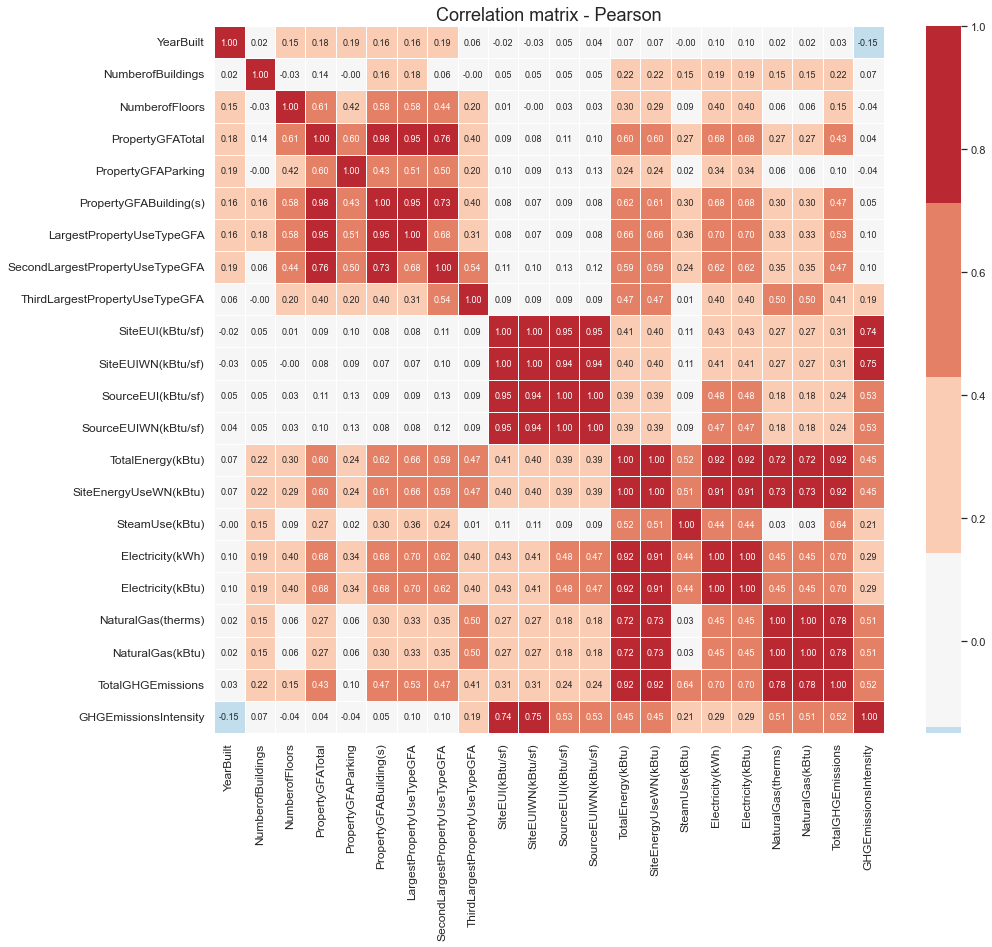

In [155]:
correlation_matrix(cleaned_data, width=15, height=13)

**Interpretation**


1) There are variables used to predict energy (electricity, steam, gas, total energy). These variables are for example YearBuilt, NumberofFloors. **We want these features used for prediction to be correlated to the target which are energy variables**.
However, **we do not want these features to be correlated between each other**.
- We won't keep features that are high correlated to other features used for prediction : PropertyGFABuilding(s), LargestPropertyUseTypeGFA' for instance.

2) The purpose of this project is to predict the CO2 (TotalGHGEmissions) using the energy predictions.
- We won't keep useless energy features : Electricity(kWh), NaturalGas(therms) for instance.
- We choose 4 energy targets (electricity, steam, gas, total energy in kBtu (same unit) ; we drop all the correlated energy features (Weather Normalized, (kBtu/sf).

In [156]:
# exploration : matrice corrélation et corrélation entre categorielles et quantitatives (GHGE corrélé avec var consom E (elctricity, steam etc)
# predict : consomation bat puis avec ca predire l'emission CO2
# 1) prediction consommation sur l'énergie puis predire CO2 (le + long le +complexe)
# categories batiments mal ecrites / numeriques incohérentes

We display here the correlation matrix without options to justify the display below.


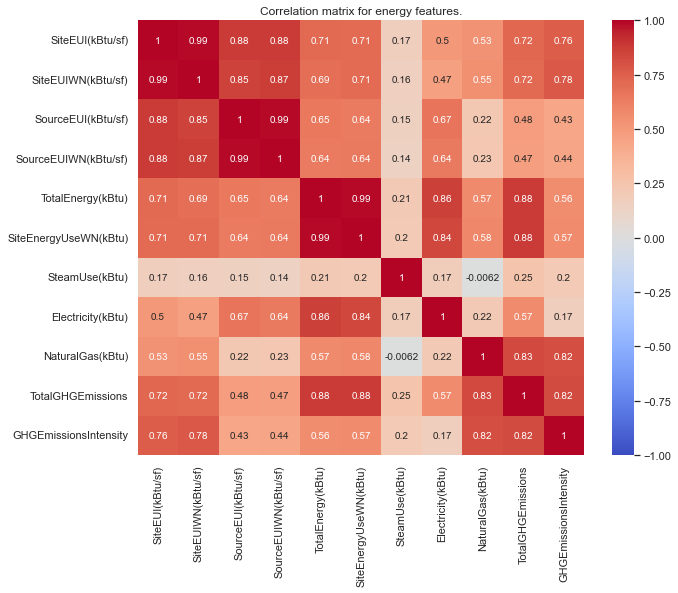

In [157]:
#### 2) Correlation between energy variables

all_energy_features = ["SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)", "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)",
                       "TotalEnergy(kBtu)", "SiteEnergyUseWN(kBtu)", "SteamUse(kBtu)", "Electricity(kBtu)",
                       "NaturalGas(kBtu)", "TotalGHGEmissions", "GHGEmissionsIntensity"]

# we create a dataframe with all the energy features.
df_to_corr = cleaned_data[all_energy_features]

# we assign the type float to all the values of the matrix
df_to_corr = df_to_corr.astype(float)
corr_df = df_to_corr.corr(method='spearman')

##### 1)
print("We display here the correlation matrix without options to justify the display below.")
plt.figure(figsize=(10, 8))
plt.title('Correlation matrix for energy features.')
sns.heatmap(corr_df, annot=True, vmin=-1, cmap='coolwarm')
plt.show()


#### 2) Correlation after cleaning

In [158]:
data_v1 = delete_correlated_variables(cleaned_data)

___Removing correlated features___
Before : (3147, 32)
After : (3147, 24)


We display here the correlation matrix without options to justify the display below.


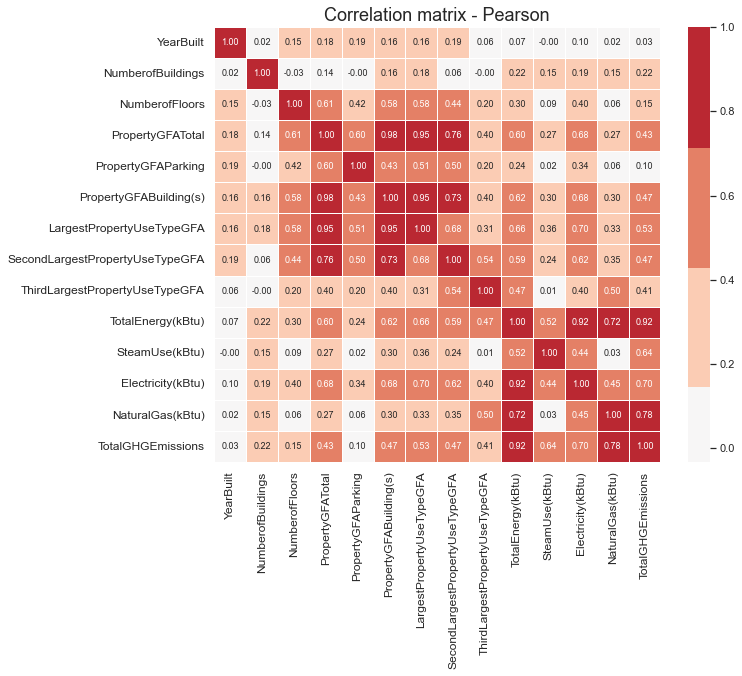

In [159]:
correlation_matrix(data_v1, width=10, height=8)

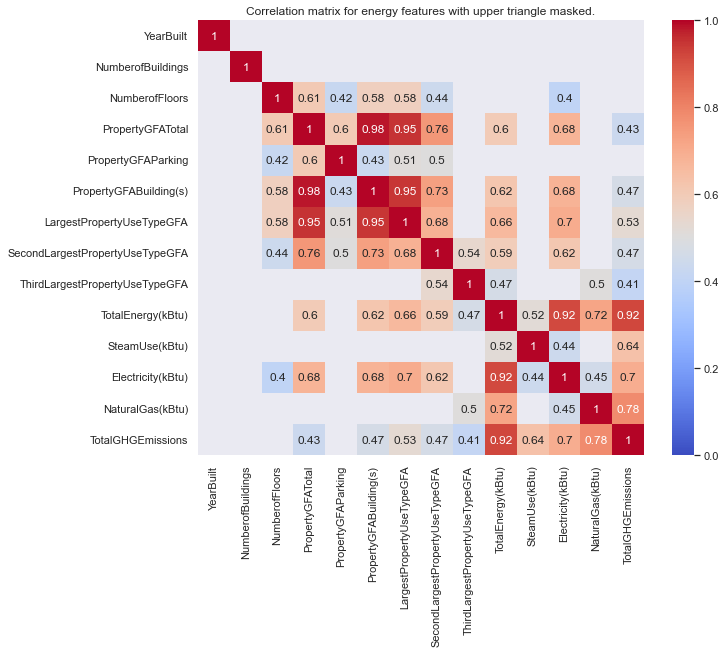

In [160]:
numeric_columns = data_v1.select_dtypes(include='number').columns.tolist()
numeric_columns.remove("ENERGYSTARScore")

df_to_corr = data_v1[numeric_columns]

# we assign the type float to all the values of the matrix
df_to_corr = df_to_corr.astype(float)
corr = df_to_corr.corr(method='pearson')



##### 2)
plt.figure(figsize=(10, 8))
sns.set(font_scale=1)
plt.title('Correlation matrix for energy features with upper triangle masked.')

# to hide the upper triangle of the matrix
#trimask = np.zeros_like(corr)
#trimask[np.triu_indices_from(trimask)] = True
sns.heatmap(corr, annot=True, mask=(np.abs(corr) <= 0.4), vmin=0,
            cmap='coolwarm')  # we don't have negative correlations here

plt.show()

** Interpretation :

Features for prediction :
- PropertyGFABuilding(s) or PropertyGFATotal
- NumberofFloors (though really correlated to other building properties)
- LargestPropertyUseTypeGFA
- SecondLargestPropertyUseTypeGFA
- ThirdLargestPropertyUseTypeGFA

Steam(kBtu) is not correlated to building properties, it might be not well predicted.
NaturalGas(kBtu) being only correlated to ThirdLargestPropertyUseTypeGFA, it might be not well predicted.


### 2) Boxplot

In [161]:
features_to_predict = ["TotalEnergy(kBtu)",
                       "SteamUse(kBtu)",
                       "Electricity(kBtu)",
                       "NaturalGas(kBtu)",
                       "TotalGHGEmissions"]

# pour prédire les 4 premieres : avec le meme groupe de var (utilisation des carstetiques des bat)

print("Features to predict : ", features_to_predict)

Features to predict :  ['TotalEnergy(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions']


#### 1) variables to predict as a function of categorical variables

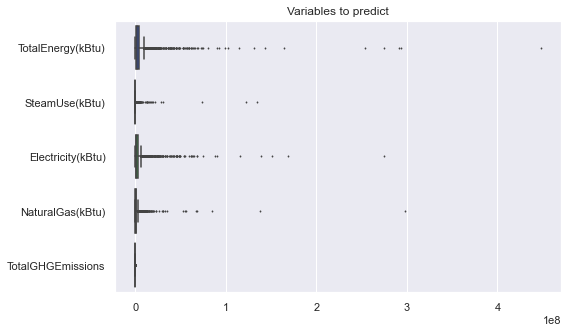

In [162]:
# Boxplot of features to predict
plt.figure(figsize=(8, 5))
plt.title('Variables to predict')
bp = sns.boxplot(x='value', y='variable', data=pd.melt(data_v1[features_to_predict]), palette='bright',
                 flierprops=dict(markersize=1, markerfacecolor='gray'))
bp.set_xlabel("")
bp.set_ylabel("")
plt.show()

#### 2) variables to predict as a function of categorical variables

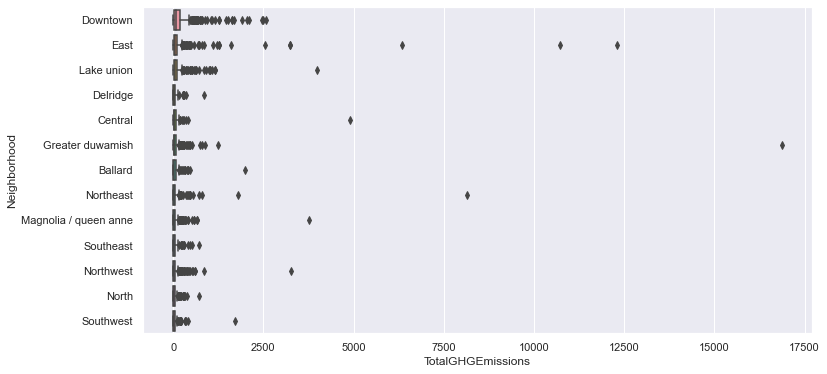

In [163]:
display_boxplot_per_feature(data_v1, all_features=["TotalGHGEmissions"], category="Neighborhood")

In [164]:
#display_boxplot_per_feature(data_v1, all_features=features_to_predict, "Neighborhood")
#display_boxplot_per_feature(data_v1, features_to_predict, "BuildingType")
#display_boxplot_per_feature(data_v1, features_to_predict, "PrimaryPropertyType")

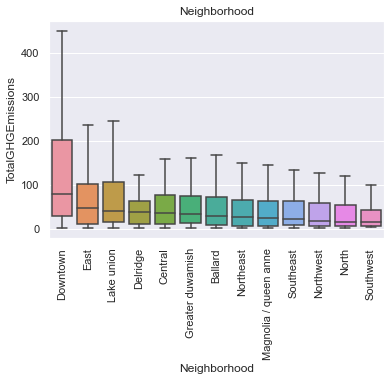

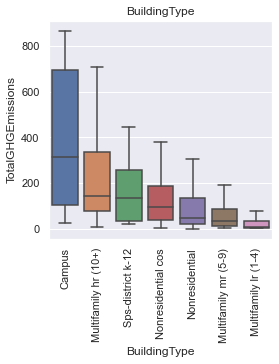

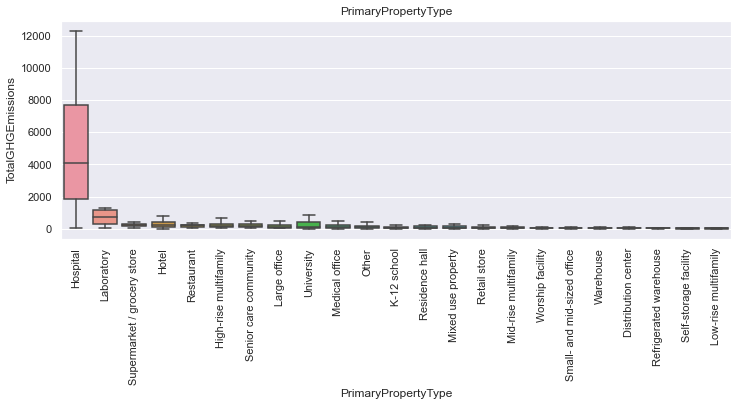

In [165]:
box_categorical(data_v1, col_categorical="Neighborhood", col_numeric="TotalGHGEmissions")
box_categorical(data_v1, col_categorical="BuildingType", col_numeric="TotalGHGEmissions")
box_categorical(data_v1, col_categorical="PrimaryPropertyType", col_numeric="TotalGHGEmissions")

### 3) Distribution of quantitative / numerical variables

#### 1) Skewness

In [166]:
print("These are the features that need a transformation :")
skew_features = get_features_skewness(data_v1)
print(skew_features)

These are the features that need a transformation :
___Getting features with skewness greater than 2___
['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'TotalEnergy(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions']


Before :
___Density distribution___


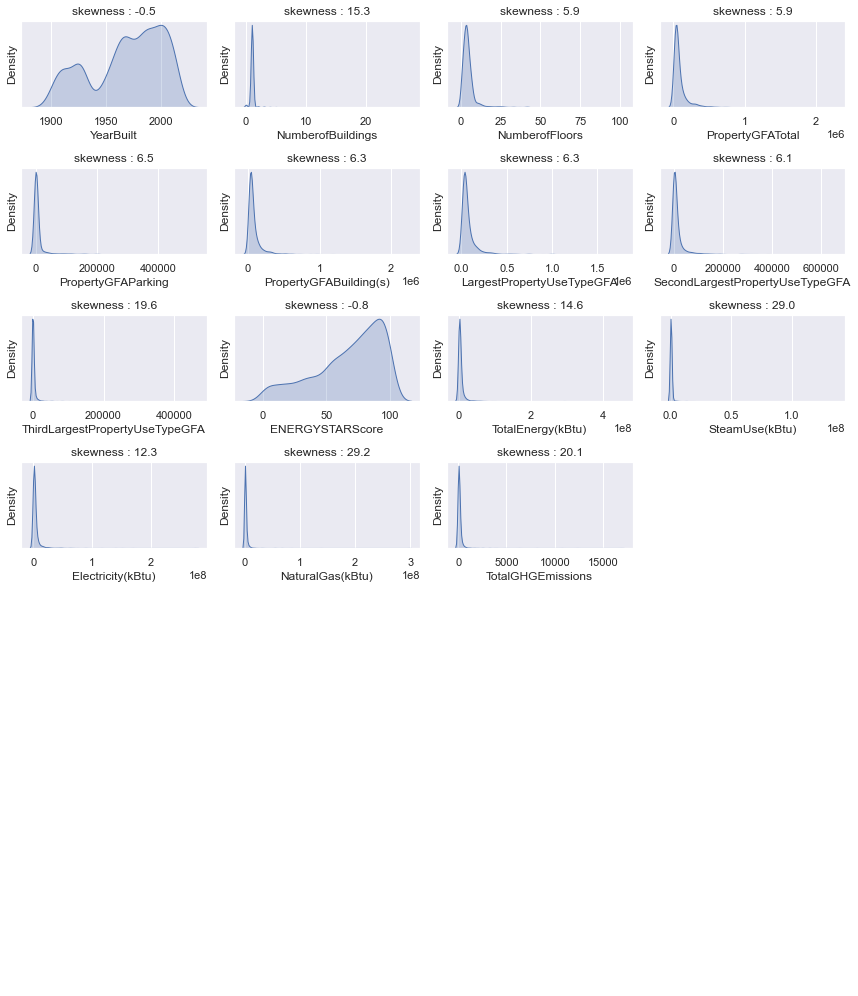

In [167]:
print("Before :")
density(data_v1)

#### 2) Logarithmic transformation

In [168]:
print("We check the effect of a log transformation on the variable we want to predict.")
#all_log_transformations = compute_log_for_feature(dataset_v2, "SiteEnergyUse(kBtu)")
#log_distribution(all_log_transformations)

We check the effect of a log transformation on the variable we want to predict.


In [169]:
print("Trying different log transformations :")
test_log = compute_log_effect_on_skewness(data_v1, skew_features)

Trying different log transformations :


In [170]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
display(test_log)

,feature,ln,log-2,log-10
0,NumberofBuildings,3.693812,3.693812,3.693812
0,NumberofFloors,0.830058,0.830058,0.830058
0,PropertyGFATotal,1.131526,1.131526,1.131526
0,PropertyGFAParking,1.997162,1.997162,1.997162
0,PropertyGFABuilding(s),1.142691,1.142691,1.142691
0,LargestPropertyUseTypeGFA,1.025807,1.025807,1.025807
0,SecondLargestPropertyUseTypeGFA,0.191329,0.191329,0.191329
0,ThirdLargestPropertyUseTypeGFA,1.873861,1.873861,1.873861
0,TotalEnergy(kBtu),0.771158,0.771158,0.771158
0,SteamUse(kBtu),4.925006,4.925006,4.925006


___Log transformation pipeline___
Before : (3147, 24)
These are the features that need a transformation :
___Getting features with skewness greater than 2___
['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'TotalEnergy(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions']
Before :
___Density distribution___


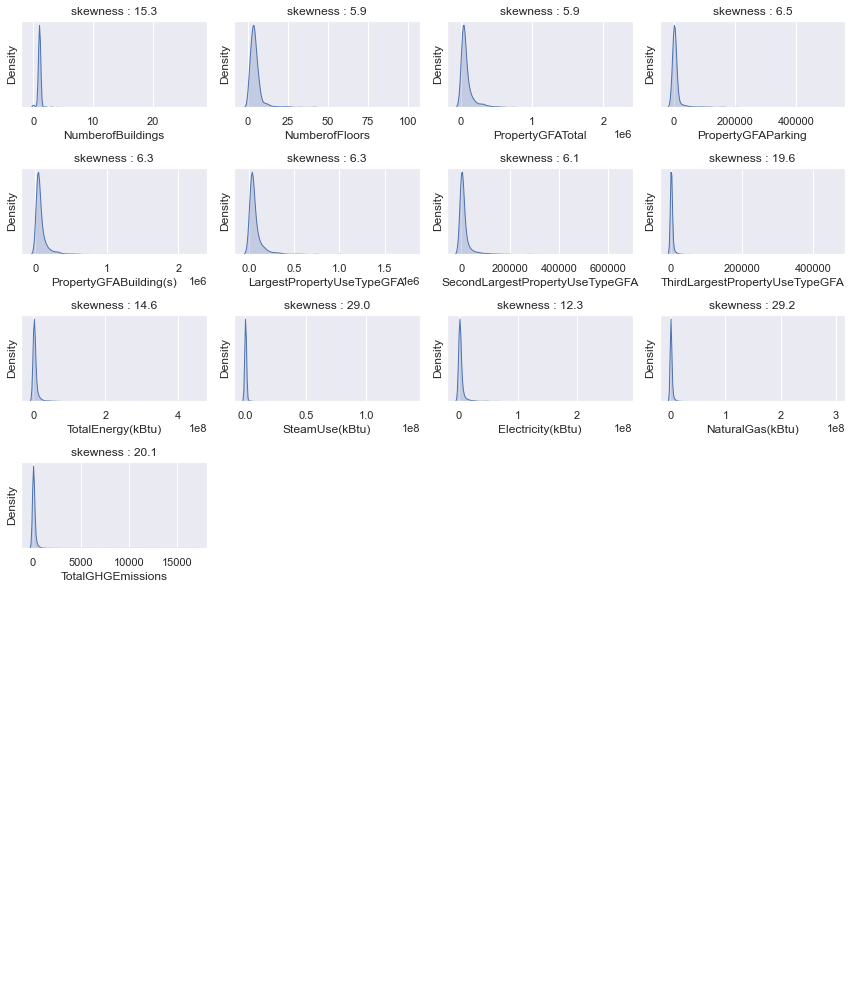

___Logarithmic transformation of features___
Log-transformation of the variables to predict.
___Density distribution___


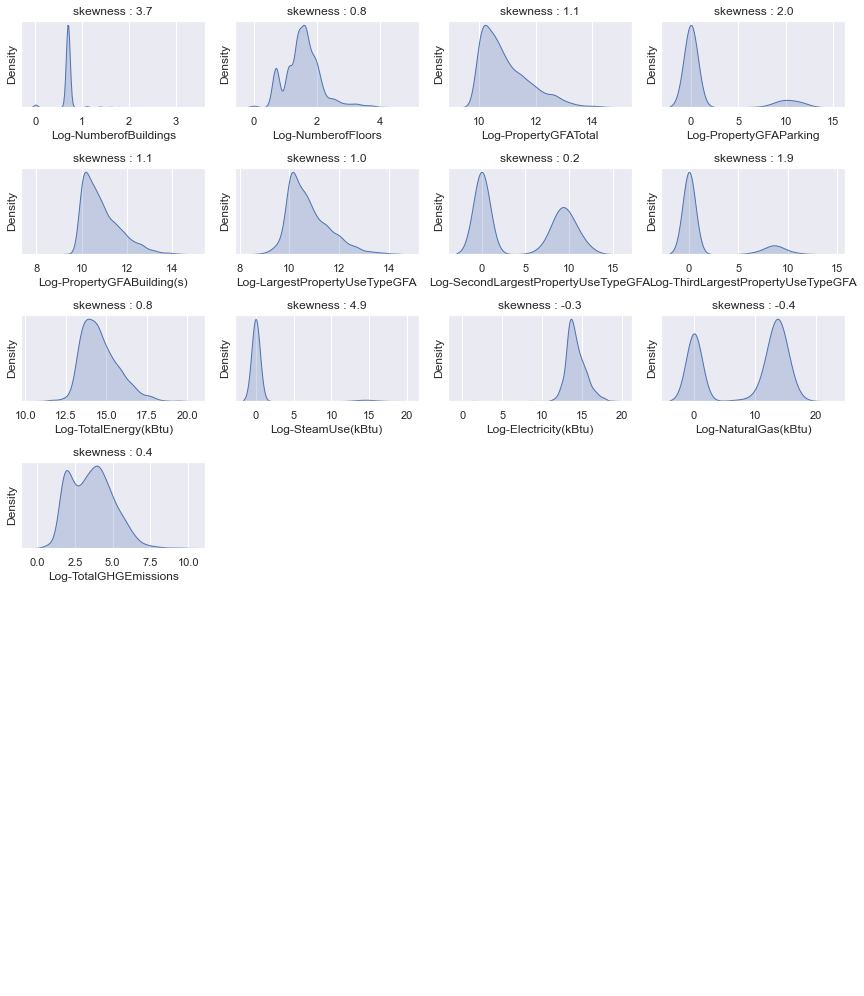

After : (3147, 37)


,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,TotalEnergy(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalEnergy(kBtu),Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalGHGEmissions
0,1,Nonresidential,Hotel,98101.0,7,Downtown,1927,1,12,88434,0,88434,Hotel,88434.000000,No use,0.000000,No use,0.000000,60.000000,7226362.500000,2003882.000000,3946027.000000,1276453.000000,249.980000,0.693147,2.564949,11.390023,0.000000,11.390023,11.390023,0.000000,0.000000,15.793246,14.510597,15.188220,14.059596,5.525373
1,2,Nonresidential,Hotel,98101.0,7,Downtown,1996,1,11,103566,15064,88502,Hotel,83880.000000,Parking,15064.000000,Restaurant,4622.000000,61.000000,8387933.000000,0.000000,3242851.000000,5145082.000000,295.860000,0.693147,2.484907,11.547974,9.620129,11.390792,11.337154,9.620129,8.438799,15.942305,0.000000,14.991964,15.453552,5.693261
2,3,Nonresidential,Hotel,98101.0,7,Downtown,1969,1,41,956110,196718,759392,Hotel,756493.000000,No use,0.000000,No use,0.000000,43.000000,72587024.000000,21566554.000000,49526664.000000,1493800.000000,2089.280000,0.693147,3.737670,13.770629,12.189532,13.540275,13.536450,0.000000,0.000000,18.100297,16.886654,17.718022,14.216834,7.645053
3,5,Nonresidential,Hotel,98101.0,7,Downtown,1926,1,10,61320,0,61320,Hotel,61320.000000,No use,0.000000,No use,0.000000,56.000000,6794584.000000,2214446.250000,2768924.000000,1811213.000000,286.430000,0.693147,2.397895,11.023878,0.000000,11.023878,11.023878,0.000000,0.000000,15.731637,14.610513,14.833970,14.409508,5.660979
4,8,Nonresidential,Hotel,98121.0,7,Downtown,1980,1,18,175580,62000,113580,Hotel,123445.000000,Parking,68009.000000,Swimming pool,0.000000,75.000000,14172606.000000,0.000000,5368607.000000,8803998.000000,505.010000,0.693147,2.944439,12.075856,11.034906,11.640272,11.723559,11.127410,0.000000,16.466822,0.000000,15.496079,15.990717,6.226556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,50093,Multifamily mr (5-9),Mid-rise multifamily,98104.0,3,East,2015,1,6,86045,8908,77137,Multifamily housing,78359.000000,Parking,8126.000000,Other - public services,1369.000000,84.000000,2161240.250000,0.000000,2161240.000000,0.000000,15.070000,0.693147,1.945910,11.362637,9.094817,11.253351,11.269069,9.002947,7.222566,14.586193,0.000000,14.586193,0.000000,2.776954
3143,50094,Nonresidential,Mixed use property,98109.0,7,Lake union,2015,1,6,345290,85028,260262,Laboratory,151523.000000,Office,106498.000000,Parking,84002.000000,NaN,39364116.000000,0.000000,23636804.000000,15727308.000000,1000.060000,0.693147,1.945910,12.752143,11.350748,12.469448,11.928499,11.575891,11.338608,17.488365,0.000000,16.978316,16.570909,6.908815
3144,50095,Multifamily mr (5-9),Mid-rise multifamily,98116.0,1,Southwest,2015,1,7,208136,58818,149318,Multifamily housing,168221.000000,Parking,44717.000000,No use,0.000000,100.000000,3552185.000000,0.000000,1988772.000000,1563413.000000,96.900000,0.693147,2.079442,12.245952,10.982220,11.913840,12.033040,10.708131,0.000000,15.083074,0.000000,14.503028,14.262382,4.583947
3145,50098,Multifamily lr (1-4),Low-rise multifamily,98122.0,3,Central,2014,1,4,20246,2580,17666,Multifamily housing,17666.000000,No use,0.000000,No use,0.000000,99.000000,789847.187500,0.000000,499926.000000,289921.000000,18.880000,0.693147,1.609438,9.915762,7.855932,9.779454,9.779454,0.000000,0.0000

In [171]:
data_v2 = log_transformation_based_on_skewness(data_v1)
display(data_v2)

After :
___Density distribution___


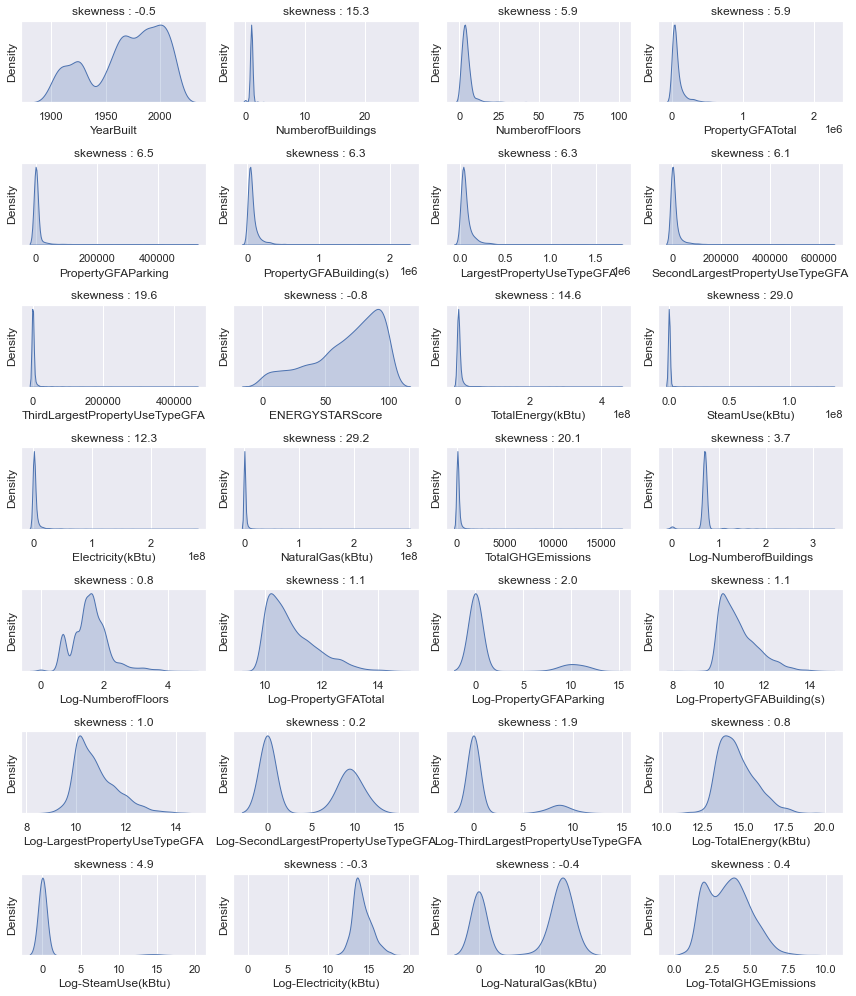

In [172]:
print("After :")
density(data_v2)

### 4) Keeping only relevant features

In [173]:
data_v3 = data_v2.copy()

In [174]:
data_v3["Ratio_Electricity"] = data_v3["Electricity(kBtu)"] / data_v3["TotalEnergy(kBtu)"]
data_v3["Ratio_Steam"] = data_v3["SteamUse(kBtu)"] / data_v3["TotalEnergy(kBtu)"]
data_v3["Ratio_Gas"] = data_v3["NaturalGas(kBtu)"] / data_v3["TotalEnergy(kBtu)"]
data_v3["Ratio_Steam+Gas"] = (data_v3["NaturalGas(kBtu)"] + data_v3["SteamUse(kBtu)"]) / data_v3["TotalEnergy(kBtu)"]


data_v3["Ratio_Other"] = (data_v3["TotalEnergy(kBtu)"] - data_v3["NaturalGas(kBtu)"] - data_v3["SteamUse(kBtu)"] - data_v3["Electricity(kBtu)"]) / data_v3["TotalEnergy(kBtu)"]

data_v3["Ratio_Steam+Gas+Other"] = (data_v3["TotalEnergy(kBtu)"] - data_v3["Electricity(kBtu)"]) / data_v3["TotalEnergy(kBtu)"]

#data_v3["Ratio_S"] = (data_v3["NaturalGas(kBtu)"] + data_v3["SteamUse(kBtu)"]) / data_v3["TotalEnergy(kBtu)"]


display(data_v3)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,TotalEnergy(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalEnergy(kBtu),Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalGHGEmissions,Ratio_Electricity,Ratio_Steam,Ratio_Gas,Ratio_Steam+Gas,Ratio_Other,Ratio_Steam+Gas+Other
0,1,Nonresidential,Hotel,98101.0,7,Downtown,1927,1,12,88434,0,88434,Hotel,88434.000000,No use,0.000000,No use,0.000000,60.000000,7226362.500000,2003882.000000,3946027.000000,1276453.000000,249.980000,0.693147,2.564949,11.390023,0.000000,11.390023,11.390023,0.000000,0.000000,15.793246,14.510597,15.188220,14.059596,5.525373,0.546060,0.277302,0.176638,0.453940,0.000000,0.453940
1,2,Nonresidential,Hotel,98101.0,7,Downtown,1996,1,11,103566,15064,88502,Hotel,83880.000000,Parking,15064.000000,Restaurant,4622.000000,61.000000,8387933.000000,0.000000,3242851.000000,5145082.000000,295.860000,0.693147,2.484907,11.547974,9.620129,11.390792,11.337154,9.620129,8.438799,15.942305,0.000000,14.991964,15.453552,5.693261,0.386609,0.000000,0.613391,0.613391,0.000000,0.613391
2,3,Nonresidential,Hotel,98101.0,7,Downtown,1969,1,41,956110,196718,759392,Hotel,756493.000000,No use,0.000000,No use,0.000000,43.000000,72587024.000000,21566554.000000,49526664.000000,1493800.000000,2089.280000,0.693147,3.737670,13.770629,12.189532,13.540275,13.536450,0.000000,0.000000,18.100297,16.886654,17.718022,14.216834,7.645053,0.682307,0.297113,0.020579,0.317693,0.000000,0.317693
3,5,Nonresidential,Hotel,98101.0,7,Downtown,1926,1,10,61320,0,61320,Hotel,61320.000000,No use,0.000000,No use,0.000000,56.000000,6794584.000000,2214446.250000,2768924.000000,1811213.000000,286.430000,0.693147,2.397895,11.023878,0.000000,11.023878,11.023878,0.000000,0.000000,15.731637,14.610513,14.833970,14.409508,5.660979,0.407519,0.325913,0.266567,0.592481,0.000000,0.592481
4,8,Nonresidential,Hotel,98121.0,7,Downtown,1980,1,18,175580,62000,113580,Hotel,123445.000000,Parking,68009.000000,Swimming pool,0.000000,75.000000,14172606.000000,0.000000,5368607.000000,8803998.000000,505.010000,0.693147,2.944439,12.075856,11.034906,11.640272,11.723559,11.127410,0.000000,16.466822,0.000000,15.496079,15.990717,6.226556,0.378802,0.000000,0.621198,0.621198,0.000000,0.621198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,50093,Multifamily mr (5-9),Mid-rise multifamily,98104.0,3,East,2015,1,6,86045,8908,77137,Multifamily housing,78359.000000,Parking,8126.000000,Other - public services,1369.000000,84.000000,2161240.250000,0.000000,2161240.000000,0.000000,15.070000,0.693147,1.945910,11.362637,9.094817,11.253351,11.269069,9.002947,7.222566,14.586193,0.000000,14.586193,0.000000,2.776954,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3143,50094,Nonresidential,Mixed use property,98109.0,7,Lake union,2015,1,6,345290,85028,260262,Laboratory,151523.000000,Office,106498.000000,Parking,84002.000000,NaN,39364116.000000,0.000000,23636804.000000,15727308.000000,1000.060000,0.693147,1.945910,12.752143,11.350748,12.469448,11.928499,11.575891,11.338608,17.488365,0.000000,16.978316,16.570909,6.908815,0.600466,0.000000,0.399534,0.399534,0.000000,0.399534
3144,50095,Multifamily mr (5-9),Mid-rise multifamily,98116.0,1,Southwest,2015,1,7,208136,58818,149318,Multifamily housing,168221.000000,Parking,44717.000000,No use,0.000000,100.000000

In [175]:
data_v3[["Ratio_Electricity", "Ratio_Steam", "Ratio_Gas", "Ratio_Steam+Gas", "Ratio_Other", "Ratio_Steam+Gas+Other"]]

,Ratio_Electricity,Ratio_Steam,Ratio_Gas,Ratio_Steam+Gas,Ratio_Other,Ratio_Steam+Gas+Other
0,0.546060,0.277302,0.176638,0.453940,0.000000,0.453940
1,0.386609,0.000000,0.613391,0.613391,0.000000,0.613391
2,0.682307,0.297113,0.020579,0.317693,0.000000,0.317693
3,0.407519,0.325913,0.266567,0.592481,0.000000,0.592481
4,0.378802,0.000000,0.621198,0.621198,0.000000,0.621198
...,...,...,...,...,...,...
3142,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3143,0.600466,0.000000,0.399534,0.399534,0.000000,0.399534
3144,0.559873,0.000000,0.440127,0.440127,0.000000,0.440127
3145,0.632940,0.000000,0.367060,0.367060,0.000000,0.367060


___Density distribution___


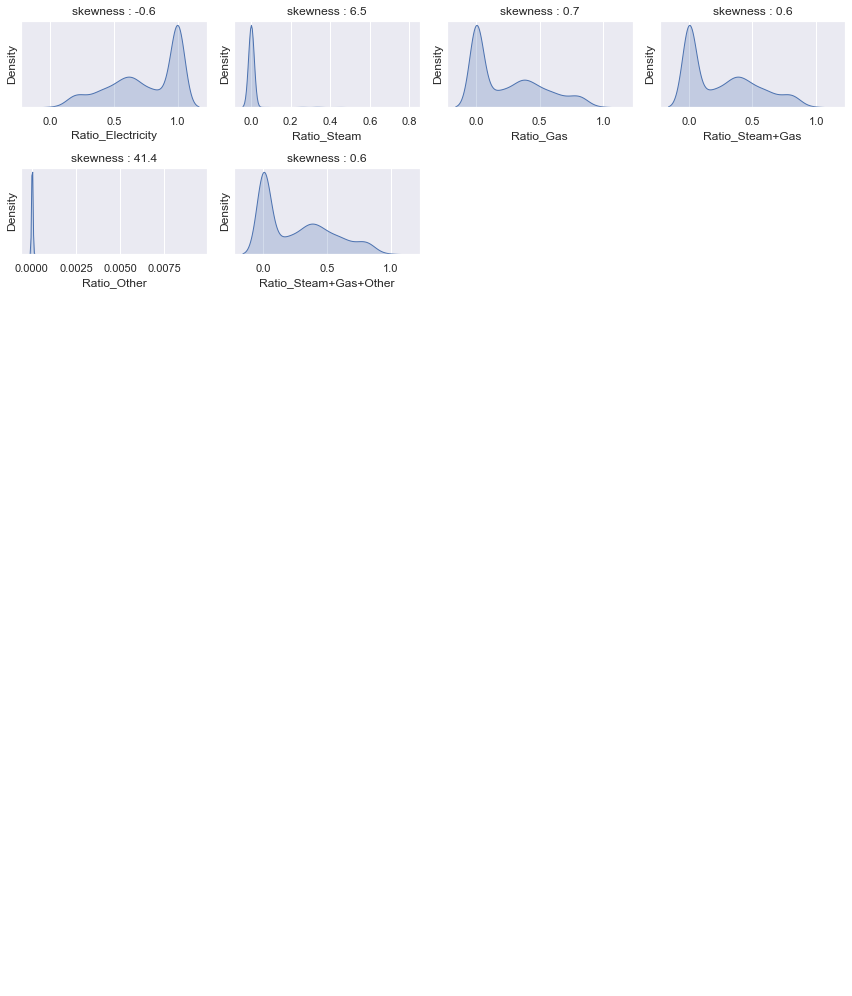

In [176]:
density(data_v3[["Ratio_Electricity", "Ratio_Steam", "Ratio_Gas", "Ratio_Steam+Gas", "Ratio_Other", "Ratio_Steam+Gas+Other"]])

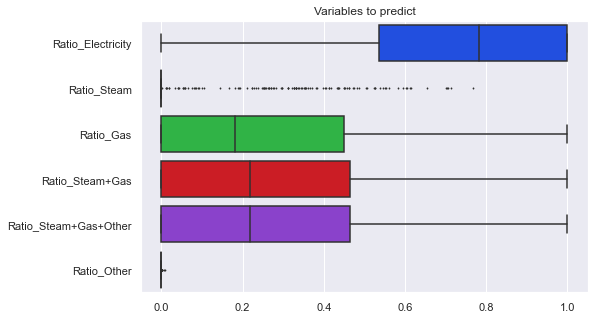

In [177]:
# Boxplot of features to predict
plt.figure(figsize=(8, 5))
plt.title('Variables to predict')
bp = sns.boxplot(x='value', y='variable', data=pd.melt(data_v3[['Ratio_Electricity',
                                                                   'Ratio_Steam',
                                                                   'Ratio_Gas',
                                                                   'Ratio_Steam+Gas', "Ratio_Steam+Gas+Other", "Ratio_Other"]]), palette='bright',
                 flierprops=dict(markersize=1, markerfacecolor='gray'))
bp.set_xlabel("")
bp.set_ylabel("")
plt.show()

In [178]:
prediction_features = ["Neighborhood", "BuildingType", "PrimaryPropertyType", "ENERGYSTARScore",
                       "YearBuilt",
                       'Log-NumberofFloors',
                       'Log-PropertyGFATotal',
                       'Log-PropertyGFABuilding(s)',
                       'Log-LargestPropertyUseTypeGFA',
                       'Log-SecondLargestPropertyUseTypeGFA',
                       'Log-ThirdLargestPropertyUseTypeGFA']
# , "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType",
# 'Log-PropertyGFABuilding(s)', 'Log-LargestPropertyUseTypeGFA',                        'Log-NumberofBuildings',


target_features = [
    'Log-TotalEnergy(kBtu)',
    'Log-SteamUse(kBtu)',
    'Log-Electricity(kBtu)',
    'Log-NaturalGas(kBtu)',
    'Ratio_Electricity',
    'Ratio_Steam',
    'Ratio_Gas',
    'Ratio_Steam+Gas',
    "Ratio_Steam+Gas+Other",
    "Ratio_Other",
    'Log-TotalGHGEmissions']

data_v4 = data_v3[prediction_features + target_features]

### 5) Saving cleaned dataset

In [179]:
# We reset the index
#final_dataset = dataset_v3.reset_index(drop=True)

# Save
output_path = "./dataset/cleaned/"
output_filename = "TESTdata_exploration.csv"
output_dataset_file = "{}{}".format(output_path, output_filename)

data_v4.to_csv(output_dataset_file, index=False)

In [180]:
# End of pipeline time
t1 = time()
print("computing time : {:8.6f} sec".format(t1 - t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1 - t0)))

computing time : 25.852309 sec
computing time : 00:00:25
